In [1]:
import lasagne
import theano
from theano import tensor as T
import sys
import numpy as np
#enable importing of notebooks
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from print_n_plot import plot_ims_with_boxes, add_bbox, plot_im_with_box

importing Jupyter notebook from print_n_plot.ipynb
importing Jupyter notebook from helper_fxns.ipynb
importing Jupyter notebook from build_hur_classif_network.ipynb
importing Jupyter notebook from data_loader.ipynb


In [56]:
def get_iou(box1,box2):
    #box1 and box2 are tensors
    #boxes are expected in x_center, y_center, width, height format
    x1,y1,w1,h1 = box1[0], box1[1], box1[2], box1[3]
    x2,y2,w2,h2 = box2[0], box2[1], box2[2], box2[3]
    xmin1, xmax1, ymin1, ymax1 = T.maximum(0, x1 - w1 / 2.), x1 + w1 /2., T.maximum(0,y1 - h1 / 2.), y1 + h1 /2.
    xmin2, xmax2, ymin2, ymax2 = T.maximum(0,x2 - w2 / 2.), x2 + w2 /2,T.maximum(0,y2 - h2 / 2), y2 + h2 /2
    inters = T.maximum(0,(T.minimum(xmax1,xmax2) - T.maximum(xmin1,xmin2)))   * \
                          T.maximum(0,(T.minimum(ymax1,ymax2) - T.maximum(ymin1,ymin2)) )
    def get_area(box_mm):
        xmin, xmax, ymin, ymax = box_mm
        return (xmax - xmin) * (ymax - ymin)
    union = get_area((xmin1, xmax1, ymin1, ymax1)) + get_area((xmin2, xmax2, ymin2, ymax2)) - inters                                                        
    
    return inters / union

In [3]:
def get_best_box(tens):
    #assumes there is a box
    #TODO: If no box over a certain confidence, then don't output a box
    #TODO: Add NMS (non -maximal suppression)
    #Links for how do it:
        #https://github.com/sunshineatnoon/Darknet.keras/blob/master/RunTinyYOLO.py#L107
    #keep it simple right now. just get the best box
    
    #flatten x,y coords
    fl_ten = tens.reshape((tens.shape[0],tens.shape[1] * tens.shape[2], tens.shape[3]))

    #filter out boxes less than 0.6?
    #fl_ten = fl_tens[:,:,4]
    
    #get best xy coord for each example
    best_ind = T.argmax(fl_ten[:,:,4], axis=1)

    #get x,y,w,h,conf from best one xy coord from each exampe
    best_xywhc = fl_ten[T.arange(fl_ten.shape[0]),best_ind,:]
    
    #convert xy coords of where on the grid back to separate x,y
    xs = best_ind // tens.shape[1]
    ys = best_ind % tens.shape[1]
    x = (xs + best_xywhc[:,0])
    y = (ys + best_xywhc[:,1])
    w = best_xywhc[:,2] * tens.shape[1]
    h = best_xywhc[:,3] * tens.shape[2]
    coords = T.stack([x,y,w,h],axis=1)
    
    return coords

In [2]:
def nms(boxes):
    pass

In [4]:
def make_test_data(nclass = 1, grid_y = 6, grid_x = 6, n_bound_box = 1, n_ex = 10,max_objs_per_image = 1 ):
    #make test data
    xi, yi, wi, hi, Ci,pi = range(5) + [range(5,5 + nclass)]
    n_channels = n_bound_box * 5 + nclass
    #xi, yi, wi, hi, Ci=[[k + (5*i) for i in range(n_bound_box)] for k in range(5)]

    #pi = range(n_channels - nclass, n_channels)



    p = np.random.random((n_ex,grid_y,grid_x,n_channels))

    g = np.zeros((n_ex,grid_y,grid_x,n_channels))
    for ex in g:

        n_objs_in_image = 1 #np.random.randint(1,max_objs_per_image,1)[0]
        r = np.random.randint(0,grid_y,n_objs_in_image * 2)
        for i in range(n_objs_in_image):
            coords = np.random.random(4)
            c = np.random.randint(0,nclass,1)[0]
            ex[r[2*i],r[2*i + 1],pi[c]] = 1.
            ex[r[2*i],r[2*i + 1],Ci] = 1.
            ex[r[2*i],r[2*i + 1],:Ci] = coords
    #         for j in range(n_bound_box):
    #             ex[r[2*i],r[2*i + 1],Ci[j]] = 1.
    #             ex[r[2*i],r[2*i + 1],(0 if j ==0 else Ci[j-1]+1):Ci[j]] = coords
    return g,p


In [5]:
def get_detec_loss(pred,gt, lc,ln):
    #TODO add in multiple bbox behavior
    
    #get number of examples and the indices of the tesnor 
    #to where x,y coirrds height width and confidence go
    nex = pred.shape[0]
    cinds = T.arange(5)
    
    #x coord indices, y coord indices, width, height, confidence
    xs,ys,ws,hs,cs = cinds[0], cinds[1], cinds[2], cinds[3], cinds[4]
    
    #index for prob vector for all classes
    ps = T.arange(5,pred.shape[3])
    
    #theano will now make elements less than or equal to 0 as zero and others 1 (so output shape is )
    obj_inds = gt[:,:, :,cs] > 0.

    #use nonzero in order to get boolean indexing  (eliminate the indices that are zero)
    #get specific x,y location of gt objects and the predicted output for that x,y location
    tg_obj = gt[obj_inds.nonzero()]
    tp_obj = pred[obj_inds.nonzero()]

    #term1
    #take the sum of squared difference between predicted and gt for the x and y corrdinate 
    s_x = T.square(tp_obj[:,xs] - tg_obj[:,xs])
    s_y = T.square(tp_obj[:,ys] - tg_obj[:,ys])
    raw_loss1 = T.sum(s_x + s_y)

    #multipily by lambda coord (the scaling factor for bbox coords)
    sterm1 = lc * raw_loss1


    #term2

    #get sum of squared diff of the sqrt of heights and widths b/w pred and gt
    s_w = T.square(T.sqrt(tp_obj[:,ws]) - T.sqrt(tg_obj[:,ws]))
    s_h = T.square(T.sqrt(tp_obj[:,hs]) - T.sqrt(tg_obj[:,hs]))
    raw_loss2 = T.sum(s_w + s_h)

    sterm2 = lc * raw_loss2


    #term3
    #get sum of squared diff between confidence for places with actual boxes of pred vs. ground truth
    s_c  = T.square(tp_obj[:,cs] - tg_obj[:,cs])
    raw_loss3 = T.sum(s_c)
    sterm3 = raw_loss3


    #term4
    #get the real coordinates where there are no objects
    no_ind  = gt[:,:,:,cs] <= 0.
    tg_no_obj = gt[no_ind.nonzero()]
    tp_no_obj = pred[no_ind.nonzero()]

    #get the sum of squared diff of the confidences for the places with no real boxes of  predicted vs. gr_truth
    s_nc = T.square(tp_no_obj[:,cs] - tg_no_obj[:,cs])

    raw_loss4 = T.sum(s_nc)

    sterm4 = ln * raw_loss4


    #term5
    #get the sum of squared diffs for prob vectors for the classes where there is an object in gt vs. pred
    s_p = T.square(tp_obj[:,ps] - tg_obj[:,ps])
    raw_loss5 = T.sum(s_p)
    sterm5 = raw_loss5
    
    #adds up terms divides by number of examples in the batch
    terms = (1. / nex) * (sterm1 + sterm2 + sterm3 + sterm4 + sterm5)
    return terms
#     fterms = theano.function([pred, gt], terms)
#     return fterms

# fterms = get_detec_train_loss( pred,gt, lam_coord, lam_noobj)
# print fterms(p,g)

In [95]:
def get_detec_acc(pred,gt):
    pbox = get_best_box(pred)
    gbox = get_best_box(gt)
    #TODO make this elementwise
    results, updates = theano.scan(fn=lambda b1,b2: get_iou(b1,b2), sequences=[pbox,gbox])
    mean_iou = T.mean(results)
    return mean_iou
    

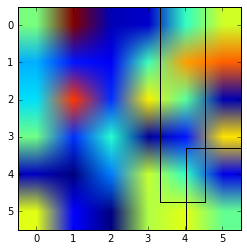

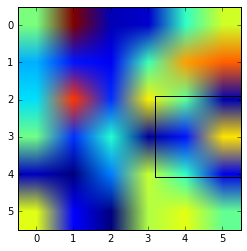

(10, 6, 6, 6)

In [74]:
# g,p = make_test_data()

# t = T.tensor4('t')

# coords = get_best_box(t)

# a=coords.eval({t:g})

# a

# b=coords.eval({t:p})

# b

# # for i in range(len(a)):
# #     get_iou(a[i],b[i])

# ims = np.random.random((g.shape[0], g.shape[1], g.shape[2]))

# plot_im_with_box(ims[0],a[9],b[9])

# plot_im_with_box(ims[0], b[6])

# g[0,5,3,0]

# g.shape




# b1 = T.vector('b1')
# b2 = T.vector('b2')

# iou = get_iou(b1,b2)

# iou.eval({b1: a[1], b2:b[1]})

